In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import cvxpy as cp

from free_flyer.free_flyer import FreeFlyer
import pickle, os

In [2]:
#load train/test data
prob = FreeFlyer() #use default config, pass different config file oth.
config_fn = './free_flyer/config/default.p'

config_file = open(config_fn,'rb')
dataset_name, _, _ = pickle.load(config_file); config_file.close()

relative_path = os.getcwd()
dataset_fn = relative_path + '/free_flyer/data/' + dataset_name

train_file = open(dataset_fn+'/train.p','rb')
# p_train, x_train, u_train, y_train, c_train, times_train = pickle.load(train_file)
train_data = pickle.load(train_file)
train_file.close()

test_file = open(dataset_fn+'/test.p','rb')
# p_test, x_test, u_test, y_test, c_test, times_test = pickle.load(test_file)
test_data = pickle.load(test_file)
test_file.close()

# test MLOPT solver

In [4]:
from solvers.mlopt import MLOPT

system = 'free_flyer'
prob_features = ['x0', 'obstacles']
mlopt_obj = MLOPT(system, prob, prob_features)

n_features = 36
mlopt_obj.construct_strategies(n_features, train_data)
print(mlopt_obj.n_strategies)

64988


In [5]:
mlopt_obj.setup_network()

fn_saved = 'models/mlopt_free_flyer_20200624_1449.pt'
mlopt_obj.load_network(fn_saved)

mlopt_obj.model

FFNet(
  (activation): ReLU()
  (layers): ModuleList(
    (0): Linear(in_features=36, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=64988, bias=True)
  )
)

In [75]:
mlopt_obj.training_params['TRAINING_ITERATIONS'] = 500
mlopt_obj.train()
print(mlopt_obj.model_fn)

/home/acauligi/cs_234/project/mlopt-micp/mlopt_free_flyer_20200624_1449.pt


In [14]:
prob_params = {}
idx = np.random.randint(test_data[1].shape[0])

p_test = test_data[0]
for k in p_test.keys():
    prob_params[k] = p_test[k][idx]
prob_success, cost, total_time, n_evals = mlopt_obj.forward(prob_params)

if prob_success:
    print(cost)
else:
    print('Failed')

46.259366513333205


In [15]:
prob_success, true_cost, solve_time, optvals = mlopt_obj.problem.solve_micp(prob_params)

true_cost

43.70009328975155

In [79]:
n_succ = 0

for ii in range(10000):
    idx = np.random.randint(train_data[1].shape[0])
    prob_params = {}
    p_test = train_data[0]
    for k in p_test.keys():
        prob_params[k] = p_test[k][idx]
    prob_success, cost, total_time, n_evals = mlopt_obj.forward(prob_params)

    if prob_success:
        n_succ += 1

print(float(n_succ)/ 10000)

0.6042


In [ ]:
idx = np.random.randint(train_data[1].shape[0])
x0 = train_data[0]['x0'][idx]
n_obs = train_data[0]['obstacles'][idx].shape[1]
posmin, posmax = mlopt_obj.problem.posmin, mlopt_obj.problem.posmax

obstacles = []
for ii_obs in range(n_obs):
    obs = train_data[0]['obstacles'][idx][:,ii_obs]
    obstacles.append(obs)

if len(obstacles) is n_obs:
    plt.axes()
    for obstacle in obstacles:
        rectangle = plt.Rectangle((obstacle[0], obstacle[2]), \
                                  obstacle[1]-obstacle[0], obstacle[3]-obstacle[2], \
                                 fc='red', ec='blue')
        plt.gca().add_patch(rectangle)
        plt.axis('scaled')

    circle = plt.Circle((x0[0],x0[1]), 0.04, fc='blue',ec="green")
    plt.gca().add_patch(circle)    

    ax = plt.gca()
    ax.margins(0)
    ax.set(xlim=(posmin[0],posmax[0]), ylim=(posmin[1],posmax[1]))
    plt.show()

# test task-specific MLOPT

In [17]:
from solvers.mlopt_ff import MLOPT_FF

In [21]:
system = 'free_flyer'
prob_features = ['x0', 'obstacles']
mlopt_ts_obj = MLOPT_FF(system, prob, prob_features)

n_features = 36 + prob.n_obs
mlopt_ts_obj.construct_strategies(n_features, train_data)
print(mlopt_ts_obj.n_strategies)

379


In [22]:
mlopt_ts_obj.setup_network()

fn_saved = 'models/mlopt_free_flyer_20200625_1311.pt'
mlopt_ts_obj.load_network(fn_saved)

mlopt_ts_obj.model

FFNet(
  (activation): ReLU()
  (layers): ModuleList(
    (0): Linear(in_features=44, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=379, bias=True)
  )
)

In [76]:
mlopt_ts_obj.training_params['TRAINING_ITERATIONS'] = 500
mlopt_ts_obj.train()
print(mlopt_ts_obj.model_fn)

/home/acauligi/cs_234/project/mlopt-micp/mlopt_free_flyer_20200625_1311.pt


In [72]:
prob_params = {}
idx = np.random.randint(test_data[1].shape[0])

p_test = test_data[0]
for k in p_test.keys():
    prob_params[k] = p_test[k][idx]
prob_success, cost, total_time, n_evals = mlopt_ts_obj.forward(prob_params)

if prob_success:
    print(cost)
else:
    print('Failed')

59.320215252808445


In [73]:
prob_success, true_cost, solve_time, optvals = mlopt_ts_obj.problem.solve_micp(prob_params)

true_cost

48.35975976723131

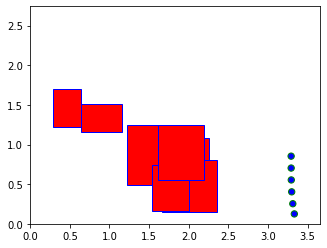

In [74]:
x0 = train_data[0]['x0'][idx]
n_obs = mlopt_ts_obj.problem.n_obs
posmin, posmax = mlopt_ts_obj.problem.posmin, mlopt_ts_obj.problem.posmax

obstacles = []
for ii_obs in range(n_obs):
    obs = train_data[0]['obstacles'][idx][:,ii_obs]
    obstacles.append(obs)

X = optvals[0]

plt.axes()
for obstacle in obstacles:
    rectangle = plt.Rectangle((obstacle[0], obstacle[2]), \
                              obstacle[1]-obstacle[0], obstacle[3]-obstacle[2], \
                             fc='red', ec='blue')
    plt.gca().add_patch(rectangle)
    plt.axis('scaled')

for ii in range(mlopt_ts_obj.problem.N):
    circle = plt.Circle((X[0,ii],X[1,ii]), 0.04, fc='blue',ec="green")
    plt.gca().add_patch(circle)

ax = plt.gca()
ax.margins(0)
ax.set(xlim=(posmin[0],posmax[0]), ylim=(posmin[1],posmax[1]))
plt.show()

# test Regression solver

In [ ]:
from solvers.regression import Regression

system = 'free_flyer'
prob_features = ['x0', 'obstacles']
reg_obj = Regression(system, prob, prob_features)

n_features = 36
reg_obj.construct_strategies(n_features, train_data)
print(reg_obj.n_strategies)

In [ ]:
reg_obj.setup_network()

reg_obj.model

In [ ]:
reg_obj.training_params['TRAINING_ITERATIONS'] = 10000
reg_obj.training_params['CHECKPOINT_AFTER'] = 200000
reg_obj.train()
print(reg_obj.model_fn)

In [ ]:
prob_params = {}
idx = np.random.randint(test_data[1].shape[0])

p_test = test_data[0]
for k in p_test.keys():
    prob_params[k] = p_test[k][idx]
prob_params

In [ ]:
prob_success, cost, total_time = reg_obj.forward(prob_params)

if prob_success:
    print(cost)
else:
    print('Failed')

In [ ]:
n_succ = 0
for idx in range(100):
    prob_params = {}

    p_test = test_data[0]
    for k in p_test.keys():
        prob_params[k] = p_test[k][idx]

    prob_success, cost, total_time = reg_obj.forward(prob_params)
    if prob_success:
        n_succ +=1

print(float(n_succ) / 100)

In [ ]:
prob_success, true_cost, solve_time, optvals = reg_obj.problem.solve_micp(prob_params)

true_cost